Задание

Основные цели этого задания:

- Научиться строить архитектуру модели
- Научиться распознавать факты переобучения и недообучения модели
- Научить бороться с переобучением и недообучением модели путем варьирования ее гиперпараметров
- Научиться применять методы регуляризации для контроля переобучения

Задача:

Построить модель нейронной сети, предсказывающую поломку программного обеспечения по его анонимным признакам. В данной задаче необходимо оптимизировать метрику ROC_AUC.

In [3]:
#!pip install shap

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from phik.report import plot_correlation_matrix
import re
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
import shap
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

План решения:

1. _Загрузите данные. Проведите EDA по вашему датасету, опишите основные идеи для последующей генерации новых признаков._

In [5]:
train = pd.read_csv('train_3.2.csv')
# Переименуем названия столбцов в соответствии с PEP8
train.columns = [re.sub('(?<!^)(?=[A-Z])|[ ]', '_', i, count=1).lower() for i in train.columns]
train.sample(5)

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,l_ocode,l_ocomment,l_oblank,loc_codeandcomment,uniq__op,uniq__opnd,total__op,total__opnd,branch_count,defects
47026,47026,19.0,2.0,1.0,2.0,66.0,317.29,0.06,17.05,18.00,...,12,0,3,0,15.0,11.0,41.0,25.0,3.0,False
98981,98981,15.0,2.0,1.0,2.0,33.0,134.89,0.13,7.62,19.95,...,11,0,2,0,11.0,9.0,20.0,13.0,3.0,False
66710,66710,12.0,3.0,1.0,3.0,23.0,85.11,0.23,4.29,22.07,...,8,0,2,0,6.0,7.0,13.0,10.0,5.0,False
61012,61012,22.0,3.0,1.0,3.0,45.0,202.05,0.09,10.67,18.94,...,14,0,4,0,12.0,9.0,29.0,16.0,5.0,False
40060,40060,20.0,3.0,3.0,2.0,41.0,174.17,0.09,11.67,14.93,...,15,0,1,0,15.0,9.0,24.0,14.0,5.0,False


In [6]:
# Возвращаем размерность
train.shape

(101763, 23)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  101763 non-null  int64  
 1   loc                 101763 non-null  float64
 2   v(g)                101763 non-null  float64
 3   ev(g)               101763 non-null  float64
 4   iv(g)               101763 non-null  float64
 5   n                   101763 non-null  float64
 6   v                   101763 non-null  float64
 7   l                   101763 non-null  float64
 8   d                   101763 non-null  float64
 9   i                   101763 non-null  float64
 10  e                   101763 non-null  float64
 11  b                   101763 non-null  float64
 12  t                   101763 non-null  float64
 13  l_ocode             101763 non-null  int64  
 14  l_ocomment          101763 non-null  int64  
 15  l_oblank            101763 non-nul

### Атрибуты

1. loc: 
   - Тип: numeric
   - Определение: Линейный подсчет строк кода по метрике МкКейба. Она используется для определения общего количества строк исходного кода в модуле.

2. v(g): 
   - Тип: numeric
   - Определение: Цикломатическая сложность по метрике МкКейба. Это количество линейных независимых путей в графе потока управления. Это помогает анализировать сложность тестирования программы.

3. ev(g):
   - Тип: numeric
   - Определение: Сущностная сложность по метрике МкКейба. Это является производной цикломатической сложности и учитывает сложность конструкций управления.

4. iv(g): 
   - Тип: numeric
   - Определение: Дизайнерская сложность по метрике МкКейба. Она указывает на качество проектирования кода на основе структуры управления.

5. n: 
   - Тип: numeric
   - Определение: Общее количество операторов и операндов по метрике Халстеда. Эта метрика помогает оценить сложность и объем кода.

6. v:
   - Тип: numeric
   - Определение: Объем программы по метрике Халстеда. Этот показатель помогает узнать, сколько информации содержит код.

7. l: 
   - Тип: numeric
   - Определение: Длина программы по метрике Халстеда. Это число говорит о размере программы в терминах операторов и операндов.

8. d: 
   - Тип: numeric
   - Определение: Сложность по метрике Халстеда (difficulty). Это измеряет трудности, связанные с написанием и пониманием кода.

9. i: 
   - Тип: numeric
   - Определение: Интеллект программы по метрике Халстеда. Определяет, насколько "умным" является код, с точки зрения работы с операторами и операндами.

10. e: 
    - Тип: numeric
    - Определение: Усилие по метрике Халстеда (effort). Этот показатель прогнозирует усилия, необходимые для понимания и поддержки программы.

11. b: 
    - Тип: numeric
    - Определение: Эта метрика может иметь различные значения в зависимости от контекста. Важно уточнить конкретное значение или описание.

12. t: 
    - Тип: numeric
    - Определение: Оценка времени разработки программы по метрике Халстеда. Предоставляет представление о времени, необходимом для работы с кодом.

13. lOCode: 
    - Тип: numeric
    - Определение: Общее количество строк кода, включая только реальные строки, но не комментарии или пустые строки.

14. lOComment: 
    - Тип: numeric
    - Определение: Количество строк комментариев в программе. Важная метрика для оценки документированности кода.

15. lOBlank: 
    - Тип: numeric
    - Определение: Количество пустых строк. Меньшее количество пустых строк может означать более компактный и, возможно, более сложный код.

16. lOCodeAndComment: 
    - Тип: numeric
    - Определение: Общее количество строк кода и комментариев вместе.

17. uniq_Op: 
    - Тип: numeric
    - Определение: Число уникальных операторов в коде, что может помочь проанализировать разнообразие использования операторов.

18. uniq_Opnd: 
    - Тип: numeric
    - Определение: Число уникальных операндов в коде. Позволяет оценить разнообразие идентификаторов и переменных.

19. total_Op: 
    - Тип: numeric
    - Определение: Общее количество операторов в коде.

20. total_Opnd: 
    - Тип: numeric
- Определение: Общее количество операндов в коде.

21. branchCount: 
    - Тип: numeric
    - Определение: Количество разветвлений в графе потока, что может помочь в понимании сложных частей кода.

22. defects: 
    - Тип: {false, true}
    - Определение: Указывает, есть ли у модуля один или несколько зарегистрированных дефектов (ошибок). Это важная метрика для оценки качества программы и ее надежности.

Каждая из этих метрик предоставляет ценную информацию о качестве, сложности и читаемости программы. Они могут быть использованы для улучшения исходного кода, а также для автоматизированного анализа кода и оценки его вероятности на наличие ошибок. 

В контексте данной работы мы решаем задачу классификации, поскольку наш таргет <span style="color: orange; font-weight: bold;">defects</span> обозначает наличие или отсутствие дефектов в модулях (значения {false, true}). Мы стремимся предсказать вероятность возникновения дефектов на основе различных метрик кода. Это позволит разработать модели, способные выявлять потенциальные проблемы еще на этапе разработки, что в свою очередь повысит качество программного обеспечения и уменьшит затраты на его исправление.

In [8]:
train['defects'] = train['defects'].astype(int)

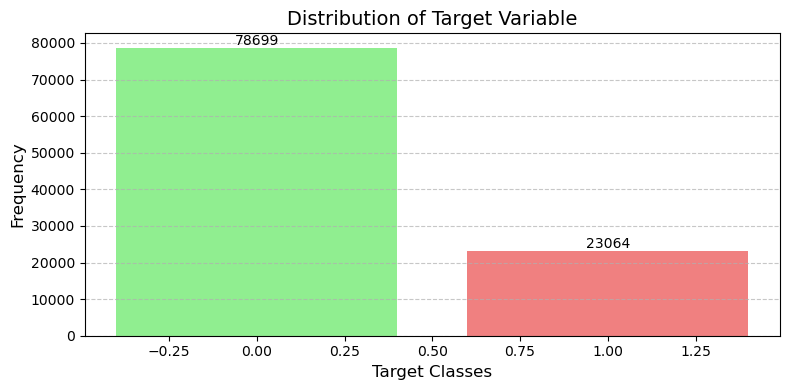

In [9]:
# Подсчет классов
target_counts = train['defects'].value_counts()

# Создание списка цветов. Давайте используем 2 цвета для разных классов
colors = ['lightgreen', 'lightcoral'] + ['lightgrey'] * (len(target_counts) - 2)

# Создание графика
plt.figure(figsize=(8, 4))
bars = plt.bar(target_counts.index, target_counts.values, color=colors)

# Заголовок и подписи
plt.title('Distribution of Target Variable', fontsize=14)
plt.xlabel('Target Classes', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0)

# Добавляем аннотации над столбцами
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom')

# Показать график
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Добавляем сетку к оси Y для чтения значений
plt.tight_layout()  # Упрощает компоновку
plt.show()

- видим дисбаланс классов у таргета

In [10]:
# Подсчет уникальных значений:
train.nunique()

id                    101763
loc                      378
v(g)                     106
ev(g)                     71
iv(g)                     84
n                        836
v                       4515
l                         55
d                       3360
i                       5171
e                       8729
b                        315
t                       8608
l_ocode                  298
l_ocomment                91
l_oblank                  94
loc_codeandcomment        29
uniq__op                  70
uniq__opnd               176
total__op                623
total__opnd              485
branch_count             144
defects                    2
dtype: int64

- Генерация корреляционной матрицы между признаками.
- Извлечение и сортировка корреляций признаков с переменной "defects".

interval columns not set, guessing: ['id', 'loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e', 'b', 't', 'l_ocode', 'l_ocomment', 'l_oblank', 'loc_codeandcomment', 'uniq__op', 'uniq__opnd', 'total__op', 'total__opnd', 'branch_count', 'defects']
Корреляция с 'defects':
defects               1.000000
l                     0.355408
i                     0.288642
branch_count          0.218708
ev(g)                 0.203205
d                     0.182513
l_oblank              0.150666
n                     0.145812
total__op             0.137578
total__opnd           0.123846
loc_codeandcomment    0.119008
v                     0.100964
loc                   0.099383
uniq__opnd            0.094858
l_ocomment            0.083963
v(g)                  0.083510
l_ocode               0.080777
b                     0.076313
iv(g)                 0.060812
uniq__op              0.042038
t                     0.027021
e                     0.025299
id                    0.000000
Name: d

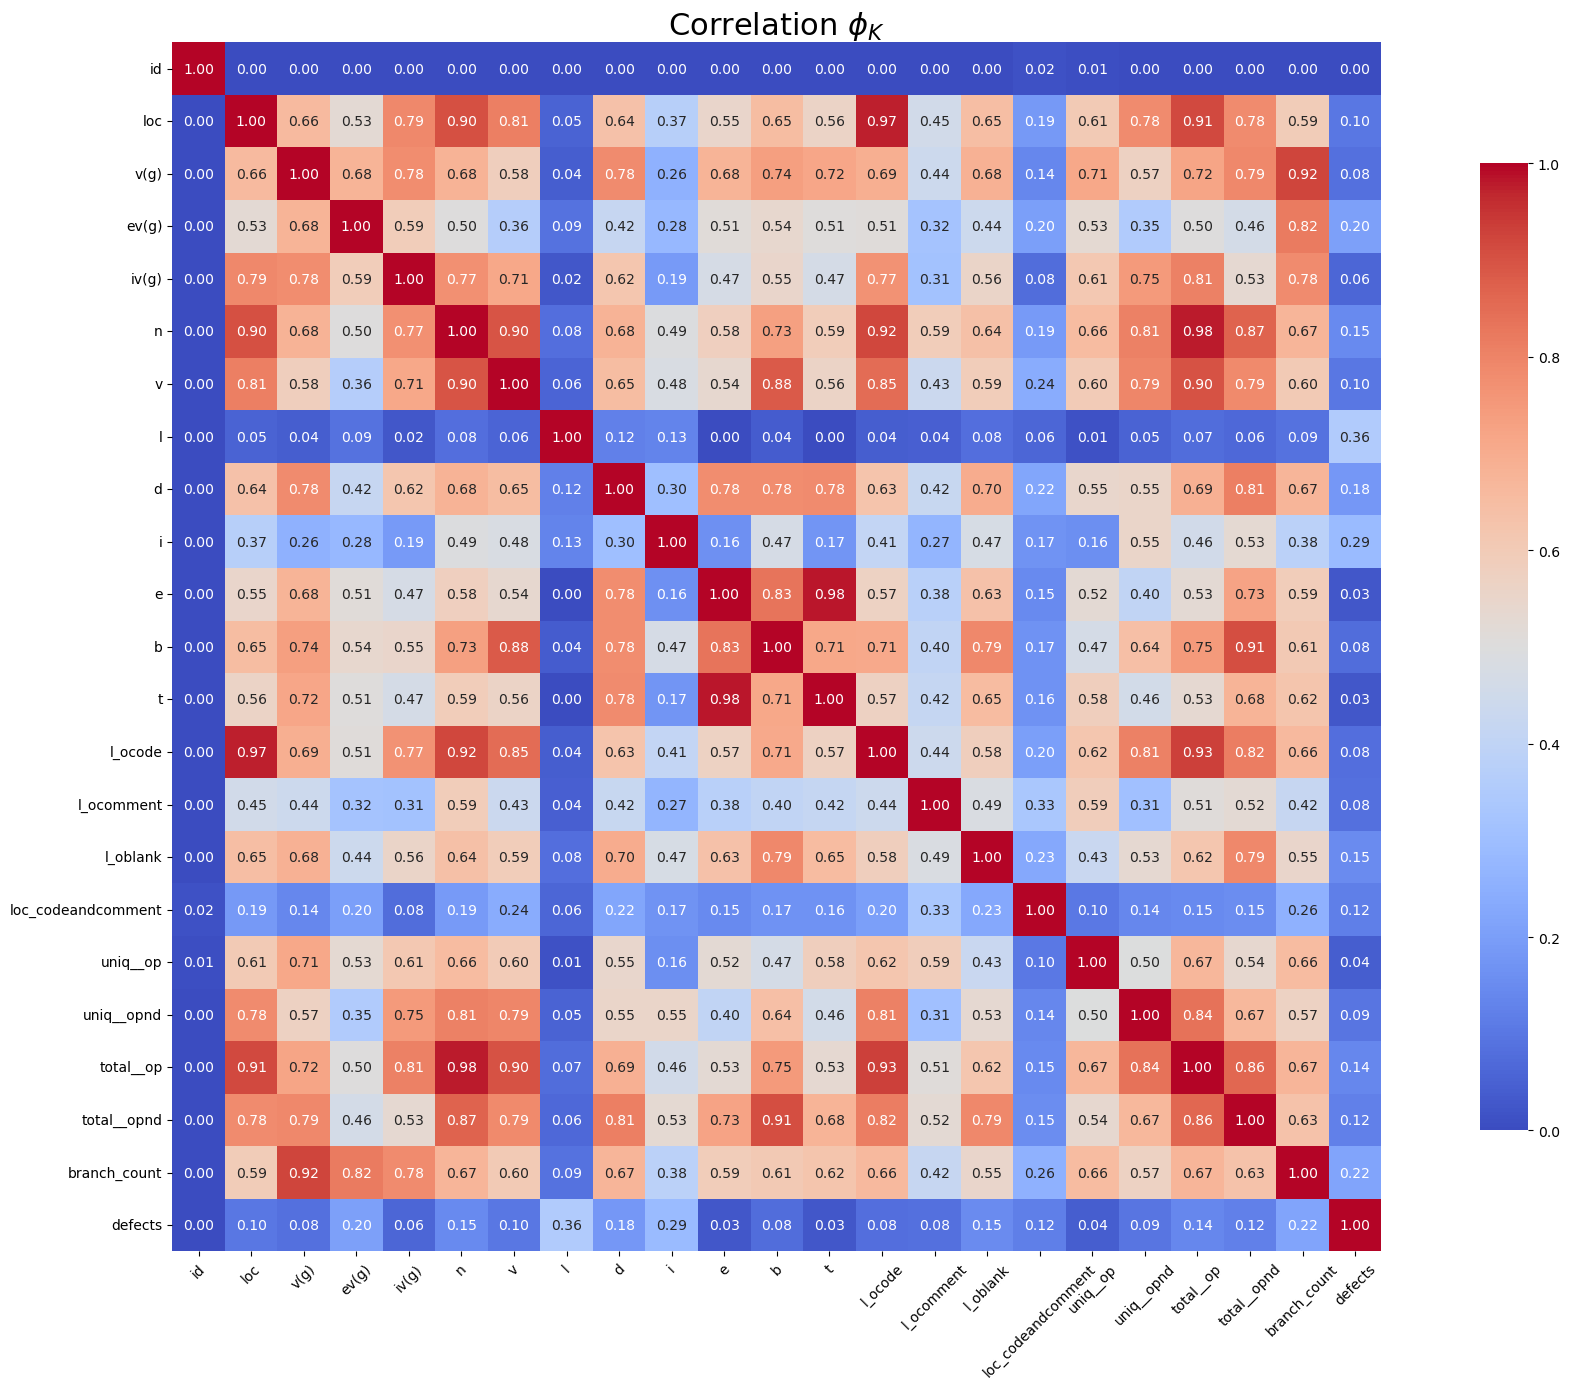

In [11]:
# Создание Phi-матрицы
phik_overview = train.phik_matrix()

# Получение корреляции с целевой переменной "defects"
defects_corr = phik_overview['defects'].sort_values(ascending=False)

# Печать корреляций с переменной "defects"
print("Корреляция с 'defects':")
print(defects_corr)

# Визуализация Phi-матрицы
def plot_correlation_matrix(matrix, x_labels, y_labels, vmin, vmax, color_map, title, fontsize_factor, figsize):
    plt.figure(figsize=figsize)
    sns.heatmap(matrix, annot=True, fmt='.2f', cmap=color_map, vmin=vmin, vmax=vmax,
                xticklabels=x_labels, yticklabels=y_labels, square=True, cbar_kws={"shrink": .8})
    plt.title(title, fontsize=fontsize_factor * 20)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

# Визуализация всей Phi-матрицы
plot_correlation_matrix(
    phik_overview.fillna(0).values, 
    x_labels=phik_overview.columns, 
    y_labels=phik_overview.index, 
    vmin=0, vmax=1, color_map="coolwarm",
    title=r"Correlation $\phi_K$", 
    fontsize_factor=1.1, figsize=(20, 14)
)

plt.tight_layout()
plt.show()

- Обучение GradientBoostingClassifier на признаках, исключая последний столбец (целевая переменная).
- Вычисление значений SHAP для оценки влияния каждого признака на предсказания модели.

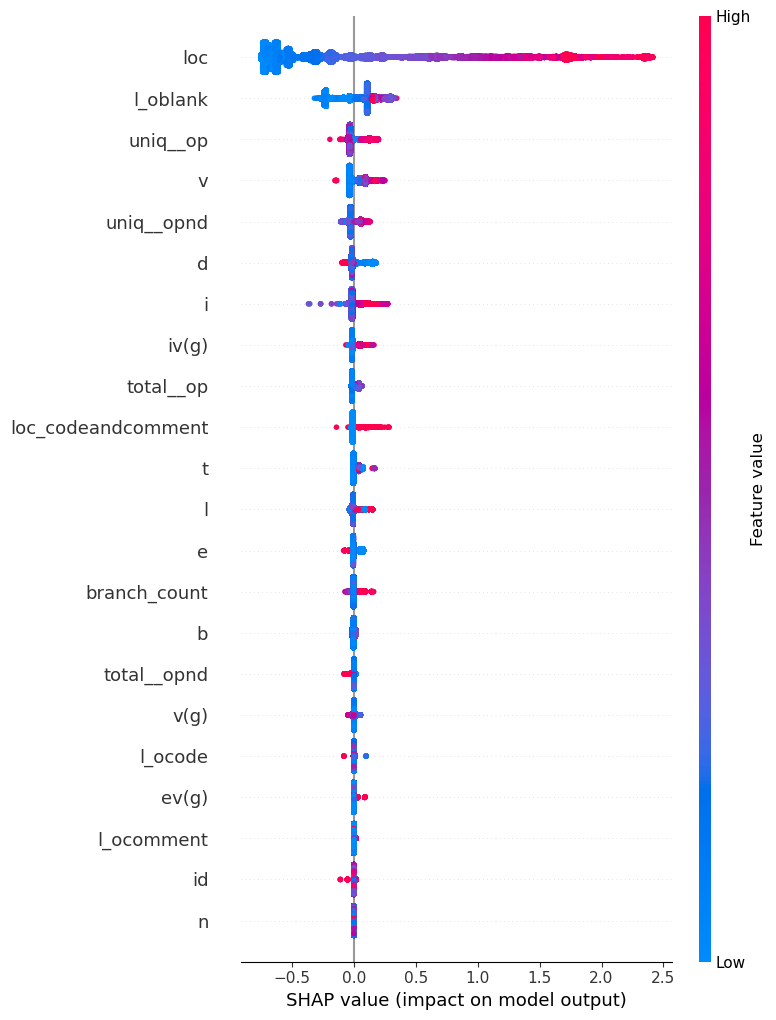

In [12]:
# Обучение модели
GBC_model = GradientBoostingClassifier(n_estimators=40, random_state=42)
GBC_model.fit(train.iloc[:, :-1], train.iloc[:, -1])  # Используем все, кроме последнего столбца как признаки

# Используем TreeExplainer от SHAP
shap_test = shap.TreeExplainer(GBC_model).shap_values(train.iloc[:, :-1])  # Принимаем только признаки для SHAP

# Визуализируем SHAP значения
shap.summary_plot(shap_test, train.iloc[:, :-1], max_display=25)  

- Создание и обучение модели RandomForestClassifier на данных, исключая целевую переменную defects.
- Извлечение важности признаков из обученной модели.

               Feature  Importance
1                  loc    0.119452
0                   id    0.088076
6                    v    0.056202
13             l_ocode    0.055540
9                    i    0.053398
10                   e    0.052065
12                   t    0.051385
2                 v(g)    0.051243
21        branch_count    0.050830
5                    n    0.046532
8                    d    0.045664
4                iv(g)    0.044340
19           total__op    0.044047
20         total__opnd    0.037826
18          uniq__opnd    0.036186
17            uniq__op    0.031801
15            l_oblank    0.029749
7                    l    0.026503
11                   b    0.025249
3                ev(g)    0.024909
14          l_ocomment    0.020318
16  loc_codeandcomment    0.008684


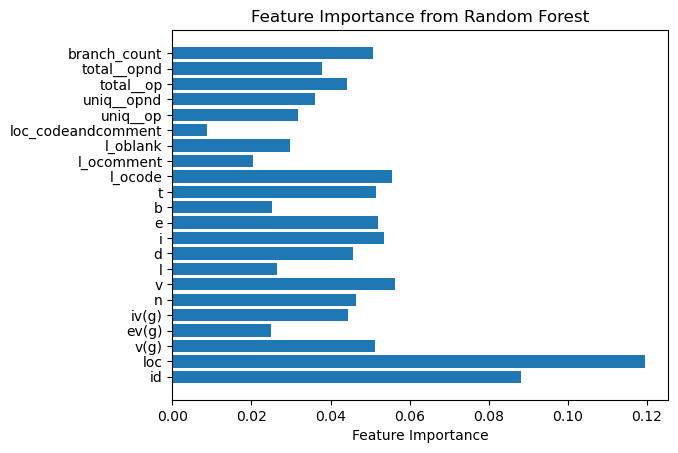

In [13]:
# Обучение модели
model = RandomForestClassifier()
model.fit(train.drop(columns=['defects']), train['defects'])

# Получение важности признаков
feature_importances = model.feature_importances_

# Создание DataFrame для удобного отображения
importance_df = pd.DataFrame({'Feature': train.drop(columns=['defects']).columns, 'Importance': feature_importances})

# Сортировка по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Печать важностей признаков
print(importance_df)

plt.barh(train.columns[:-1], feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest')
plt.show()

- Boxplot позволяет выявить выбросы и понять распределение значений в каждом признаке.

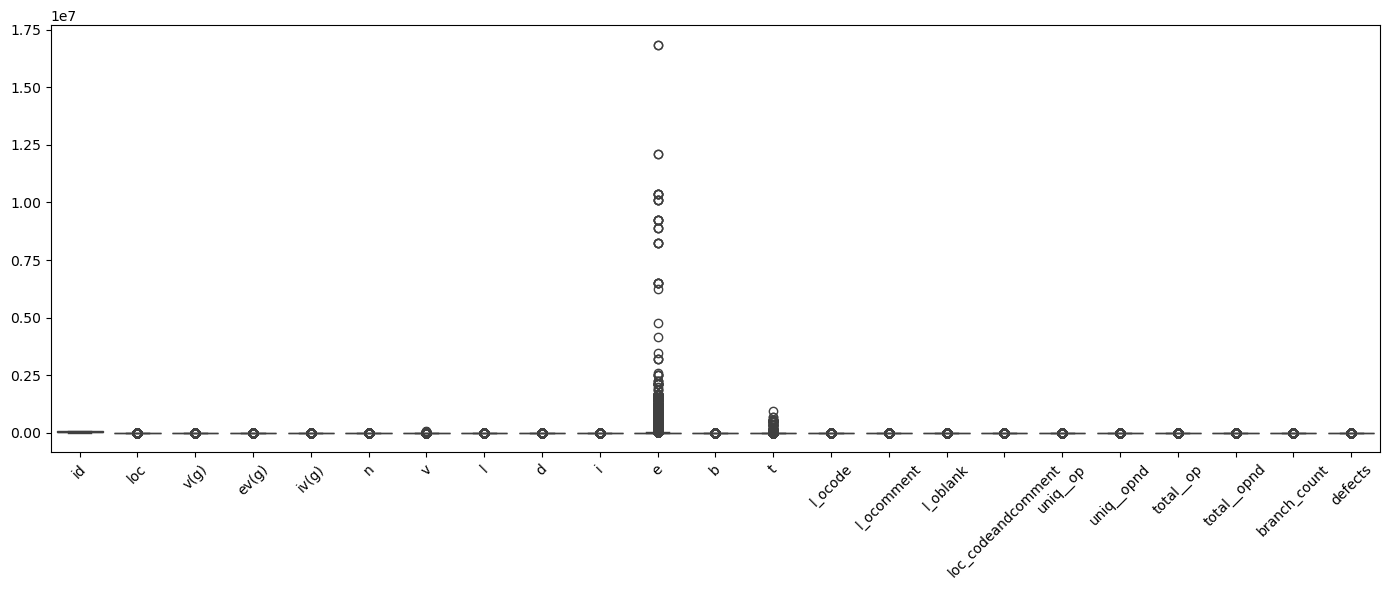

In [14]:
plt.figure(figsize=(14, 6))  # Изменяем размер графика
sns.boxplot(data=train)  # Строим графики распределения для датасета
plt.xticks(rotation=45)  # Поворачиваем названия колонок на 45 градусов
plt.tight_layout()  # Подгоняем элементы графика
plt.show()  # Отображаем график

2. _Проведите разбиение на тренировочные и валидационные данные. Проведите необходимую предобработку данных для последующего обучения нейронной сети._

In [15]:
X = train.drop('defects', axis=1)  # Выделяем признаки
y = train['defects']  # Выделяем целевую переменную

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
# Применение стандартизации к обучающему набору данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

3. _Реализуйте функцию, в которой вы будете определять архитектуру модели. Функция должна возвращать скомпилированную модель._

In [18]:

y_train, y_val = y_train.to_numpy(), y_val.to_numpy()


In [19]:
def create_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[AUC(name='roc_auc')]
                  )
    
    return model

In [20]:
# Получение весов классов
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights

array([0.64653187, 2.20611349])

4. _Обучите модель нейронной сети (без использования методов регуляризации) на исходной тренировочной выборке (без добавления новых признаков). В процессе обучения нужно отслеживать метрику ROC_AUC на каждой эпохе, на валидационных данных._

In [21]:
model = create_model()

history = model.fit(X_train, y_train,
           validation_data=(X_val, y_val),
           epochs=20,
           batch_size=256,
           class_weight={0:class_weights[0], 1:class_weights[1]})

# Вычисляем предсказания вероятностей на тестовых данных
test_pred_proba = model.predict(X_train)

# Вычисляем ROC AUC с помощью roc_auc_score из sklearn
roc_auc = roc_auc_score(y_train, test_pred_proba)

# Выводим результат
print(f'ROC AUC Score (sklearn): {roc_auc:.4f}')

c:\Users\olyao\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5843 - roc_auc: 0.7562 - val_loss: 0.5351 - val_roc_auc: 0.7898
Epoch 2/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5547 - roc_auc: 0.7877 - val_loss: 0.5461 - val_roc_auc: 0.7905
Epoch 3/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5551 - roc_auc: 0.7886 - val_loss: 0.5325 - val_roc_auc: 0.7903
Epoch 4/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5555 - roc_auc: 0.7885 - val_loss: 0.5589 - val_roc_auc: 0.7917
Epoch 5/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5559 - roc_auc: 0.7872 - val_loss: 0.5504 - val_roc_auc: 0.7913
Epoch 6/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5545 - roc_auc: 0.7916 - val_loss: 0.5328 - val_roc_auc: 0.7911
Epoch 7/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5525 - roc_auc: 0.7916 - val_loss: 0.5481 - val_roc_auc: 0.7910
Epoch 8/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5516 - roc_auc: 0.7917 - val_loss: 0.5337 - val_roc_auc:

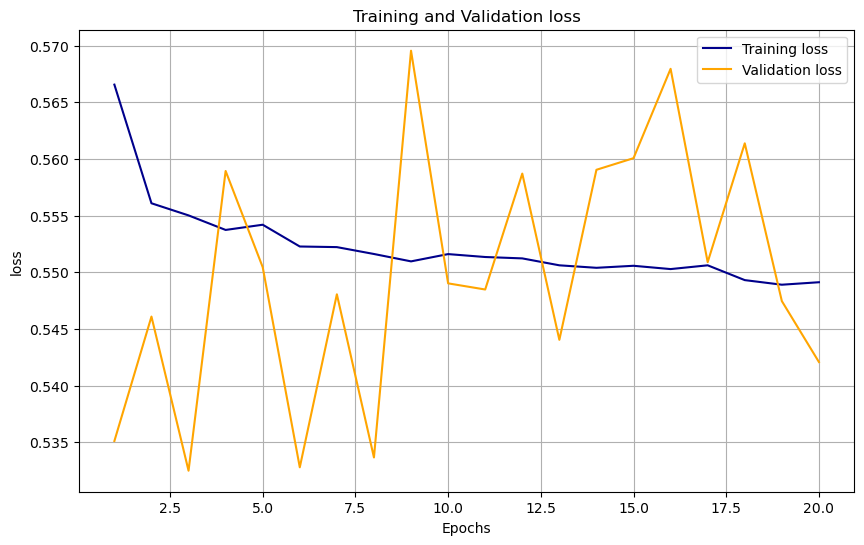

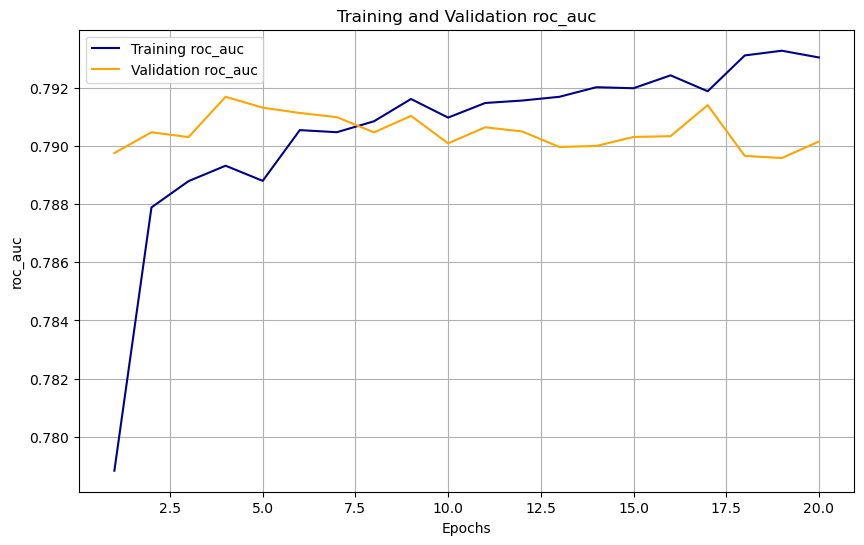

In [22]:
# Получение значений лосса и валидационного лосса из истории
def check_metrics(history, metric_name):
    """
    Функция для проверки и визуализации метрик обучения.

    Параметры:
    - history: объект истории, возвращаемый методом fit()
    - metric_name: название метрики для построения графика (например, 'loss', 'auc')

    """
    # Получаем значения для заданной метрики
    train_metrics = history.history[metric_name]
    val_metrics = history.history[f'val_{metric_name}']

    # Построение графика
    epochs = range(1, len(train_metrics) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_metrics, label=f'Training {metric_name}', color='darkblue')
    plt.plot(epochs, val_metrics, label=f'Validation {metric_name}', color='orange')
    
    # Настройка графика
    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid()
    plt.show()

# Использование функции для построения графиков лосса и AUC
check_metrics(history, 'loss')
check_metrics(history, 'roc_auc')  # Для метрики AUC


Делаем вывод на основе графиков:

 Переобучение (Overfitting):
   - Переобучение происходит, когда модель хорошо обучается на обучающих данных, но не может обобщать на валидационных данных. Это может привести к тому, что training loss снижается, в то время как validation loss начинает колебаться или даже увеличиваться. Модель "запоминает" особенности обучающего набора данных, но не может правильно обрабатывать новые данные.

 Шум в данных:
   - Если в валидационном наборе данных есть шум или выбросы, это может вызвать колебания в validation loss. Обучающие данные могут быть более чистыми и упорядоченными, что приводит к более плавному снижению при обучении.

 Размер валидационного набора:
   - Если размер вашего валидационного набора мал, колебания метрик на валидации могут быть более заметны, так как небольшие изменения в ошибках модели могут существенно повлиять на средние значения.

 Оптимизация гиперпараметров:
   - Может понадобиться настройка гиперпараметров, таких как скорость обучения или регуляризация. Если скорость обучения слишком высока, это может привести к нестабильности в процессе оптимизации.

 Архитектура модели:
   - Степень сложности модели может повлиять на способность обобщения. Слишком сложная модель может привести к переобучению, тогда как слишком простая может не обеспечить необходимую гибкость.

5. _Сгенерируйте новые признаки исходя из вашего EDA или наоборот — удалите ненужные признаки, которые препятствуют лучшему качеству модели при обучении._

In [23]:
df = pd.read_csv('train_3.2.csv')
# Переименуем названия столбцов в соответствии с PEP8
df.columns = [re.sub('(?<!^)(?=[A-Z])|[ ]', '_', i, count=1).lower() for i in df.columns]

In [24]:
df.columns

Index(['id', 'loc', 'v(g)', 'ev(g)', 'iv(g)', 'n', 'v', 'l', 'd', 'i', 'e',
       'b', 't', 'l_ocode', 'l_ocomment', 'l_oblank', 'loc_codeandcomment',
       'uniq__op', 'uniq__opnd', 'total__op', 'total__opnd', 'branch_count',
       'defects'],
      dtype='object')

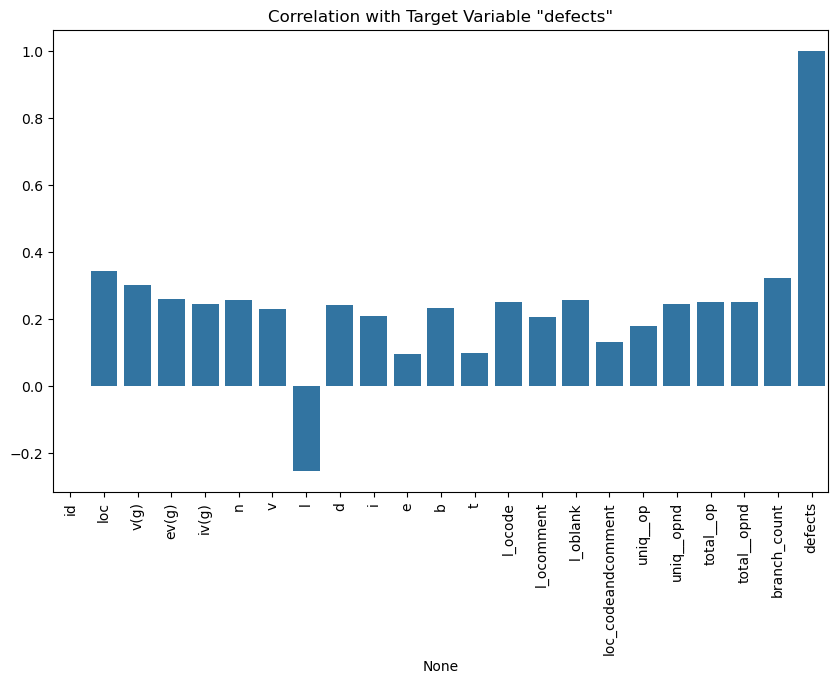

Important Features:
 loc                   0.342642
v(g)                  0.301187
ev(g)                 0.259928
iv(g)                 0.245618
n                     0.258080
v                     0.231179
l                    -0.253237
d                     0.241936
i                     0.208577
b                     0.232594
l_ocode               0.250604
l_ocomment            0.205402
l_oblank              0.257819
loc_codeandcomment    0.133150
uniq__op              0.178474
uniq__opnd            0.246113
total__op             0.250533
total__opnd           0.252752
branch_count          0.322827
defects               1.000000
Name: defects, dtype: float64


In [25]:
# Вычисляем корреляцию между признаками и целевой переменной
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['defects']

# Отображаем корреляцию с целевой переменной
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values)
plt.xticks(rotation=90)
plt.title('Correlation with Target Variable "defects"')
plt.show()

# Отбираем признаки с высокой корреляцией (например, > 0.1 или < -0.1)
important_features = correlation_with_target[abs(correlation_with_target) > 0.1]
print('Important Features:\n', important_features)

- данный метод не повлиял на улучшение значения метрики roc_auc

- добавим новые признаки в df

In [26]:
# Соотношение объема к сложности
df['volume_to_difficulty'] = df['v'] / (df['d'] + 1e-10)  # Добавление малой константы для избежания деления на ноль
# Описание: Соотношение объема к сложности, показывает эффективность 

# Индекс качества кода
df['code_quality_index'] = (df['l_ocode'] + 0.5 * df['l_ocomment'] - 0.5 * df['l_oblank'])
# Описание: Индекс качества кода, учитывает строки кода, комментарии и пустые строки

# Общее количество уникальных операторов и операндов
df['total_unique'] = df['uniq__op'] + df['uniq__opnd']
# Описание: Общее количество уникальных операторов и операндов

# Общее количество всех операторов и операндов
df['total_operations'] = df['total__op'] + df['total__opnd']
# Описание: Общее количество всех операторов и операндов

# Соотношение ветвлений к количеству строк кода
df['branch_to_code_ratio'] = df['branch_count'] / (df['loc'] + 1e-10)
# Описание: Соотношение количества ветвлений к количеству строк кода, показывает сложность управления потоком

- данный метод создания новых признаков не помог улучшить результаты roc_auc в дальнейшем

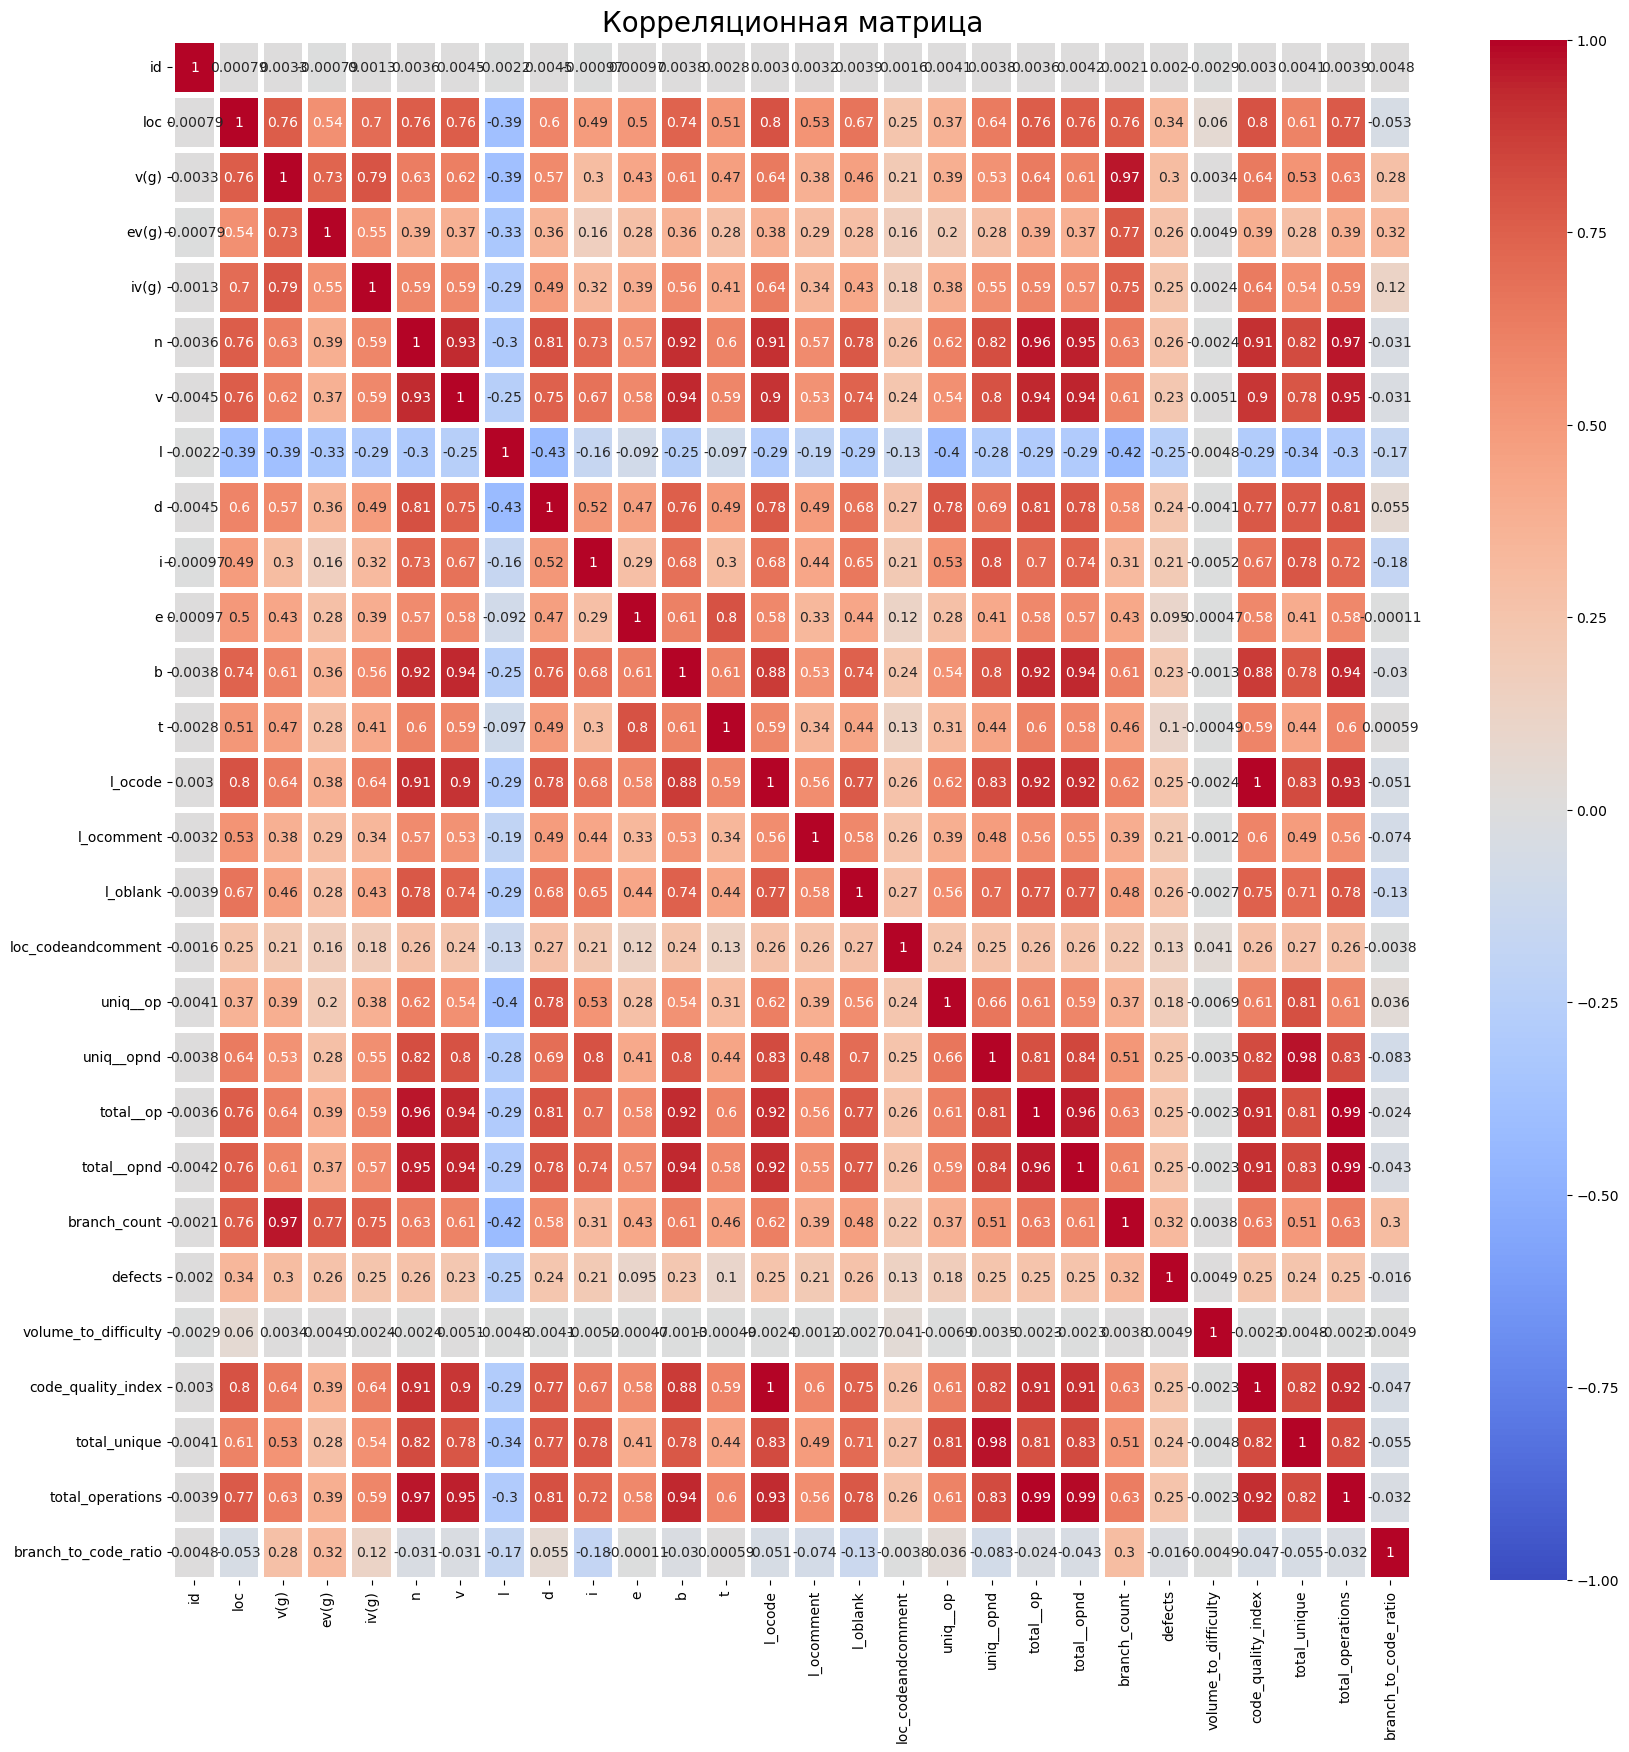

In [27]:
# Рассчитываем матрицу корреляции
corr_matrix = df.corr()

# Настройка размера графика
fig, ax = plt.subplots(figsize=(20, 20))

# Построение тепловой карты
sns.heatmap(
    corr_matrix, 
    annot=True,      # Включаем аннотации
    vmin=-1, 
    vmax=1, 
    center=0, 
    cmap='coolwarm', 
    linewidths=3,
    linecolor='white', 
    ax=ax
)

# Отображение графика
plt.title('Корреляционная матрица', fontsize=20)
plt.show()

In [28]:
# 1. Рассчитываем матрицу корреляции
corr_matrix = df.corr().abs()  # Берем абсолютные значения корреляции

# 2. Задаем порог для высоких корреляций
threshold = 0.9  # Выберите значение порога, выше которого столбцы будут удалены

# 3. Находим пары столбцов с высокой корреляцией
to_drop = set()  # Создаем множество для хранения имен столбцов для удаления

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > threshold:  # Если корреляция выше порога
            colname = corr_matrix.columns[i]  # Выберите имя столбца
            to_drop.add(colname)

# Удаляем столбцы с высокой корреляцией
df_no_corr = df.drop(columns=to_drop)  # Обновленный DataFrame

# Проверяем форму DataFrame после удаления столбцов
print("Форма DataFrame после удаления столбцов с высокой корреляцией:", df_no_corr.shape)

# Если вам нужно увидеть, какие столбцы были удалены:
print("Удаленные столбцы:", to_drop)


Форма DataFrame после удаления столбцов с высокой корреляцией: (101763, 19)
Удаленные столбцы: {'b', 'v', 'branch_count', 'total__op', 'l_ocode', 'total_unique', 'code_quality_index', 'total__opnd', 'total_operations'}


- данный метод так же не помог улучшить результат

In [29]:
# # 4. Создаем списки границ для выбросов
# lower_bounds = {}
# upper_bounds = {}

# # 5. Вычисляем границы для каждого числового признака
# for feature in df_no_corr.select_dtypes(include=[np.number]).columns:  # Обрабатываем только числовые столбцы
#     Q1 = df_no_corr[feature].quantile(0.25)
#     Q3 = df_no_corr[feature].quantile(0.75)
#     IQR = Q3 - Q1
    
#     # Устанавливаем границы для выбросов
#     lower_bounds[feature] = Q1 - 1.5 * IQR
#     upper_bounds[feature] = Q3 + 1.5 * IQR

# # 6. Удаляем верхние выбросы из DataFrame
# mask = np.ones(len(df_no_corr), dtype=bool)  # Изначально все записи считаем надежными
# for feature in df_no_corr.select_dtypes(include=[np.number]).columns:
#     # Удаляем только верхние выбросы
#     mask &= (df_no_corr[feature] <= upper_bounds[feature])

# df_no_outliers = df_no_corr[mask]

# # Проверка размера данных до и после удаления выбросов
# print(f"Размер оригинального датасета: {df.shape[0]}")
# print(f"Размер датасета после удаления выбросов: {df_no_outliers.shape[0]}")

- данный метод ухудшил результат в следствии чего был "закомменчен"

In [30]:
# import numpy as np

# # 4. Создаем список границ для верхнего 5-процентного значений
# upper_bounds = {}

# # 5. Вычисляем 95-й процентиль для каждого числового признака
# for feature in df_no_corr.select_dtypes(include=[np.number]).columns:  # Обрабатываем только числовые столбцы
#     upper_bounds[feature] = df_no_corr[feature].quantile(0.95)

# # 6. Удаляем верхние 5% из DataFrame
# mask = np.ones(len(df_no_corr), dtype=bool)  # Изначально все записи считаем надежными
# for feature in df_no_corr.select_dtypes(include=[np.number]).columns:
#     # Сохраняем только те значения, которые меньше или равны 95-му процентилю
#     mask &= (df_no_corr[feature] <= upper_bounds[feature])

# df_no_outliers = df_no_corr[mask]

# # Проверка размера данных до и после удаления верхних 5%
# print(f"Размер оригинального датасета: {df.shape[0]}")
# print(f"Размер датасета после удаления верхних 5%: {df_no_outliers.shape[0]}")

- данный метод так же ухудшил результат

In [31]:
df_no_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    101763 non-null  int64  
 1   loc                   101763 non-null  float64
 2   v(g)                  101763 non-null  float64
 3   ev(g)                 101763 non-null  float64
 4   iv(g)                 101763 non-null  float64
 5   n                     101763 non-null  float64
 6   l                     101763 non-null  float64
 7   d                     101763 non-null  float64
 8   i                     101763 non-null  float64
 9   e                     101763 non-null  float64
 10  t                     101763 non-null  float64
 11  l_ocomment            101763 non-null  int64  
 12  l_oblank              101763 non-null  int64  
 13  loc_codeandcomment    101763 non-null  int64  
 14  uniq__op              101763 non-null  float64
 15  

6. _Переобучите модель на данных, которые представляют из себя новый датафрейм, и оцените, как изменилось качество модели (то есть вы либо добавили новые признаки, либо удалили старые, либо всё вместе). Исходя из этого примите решение, какие новые признаки хорошо повлияли на качество, а какие нет._

In [32]:
features = df_no_corr.drop('defects', axis=1)  # Выделяем признаки
target = df_no_corr['defects']  # Выделяем целевую переменную

In [33]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, stratify=target, random_state=42
)

In [34]:
target_train, target_test = target_train.to_numpy(), target_test.to_numpy()

- код обучает модель Random Forest и оценивает важность признаков

Feature ranking:
1. loc (0.13800255750181678)
2. id (0.09537006160369402)
3. branch_to_code_ratio (0.06810309151685773)
4. e (0.06646328062564444)
5. volume_to_difficulty (0.0646329517358179)
6. n (0.0643991086372001)
7. t (0.06342022835890464)
8. i (0.06200922844946106)
9. iv(g) (0.055168155054746724)
10. d (0.053154858041788)
11. v(g) (0.049874032754861096)
12. uniq__opnd (0.04557807857407582)
13. l (0.04133829132022358)
14. uniq__op (0.03618707154765582)
15. l_oblank (0.035614270825897805)
16. ev(g) (0.027643109925900543)
17. l_ocomment (0.023102338707923806)
18. loc_codeandcomment (0.009939284817530057)


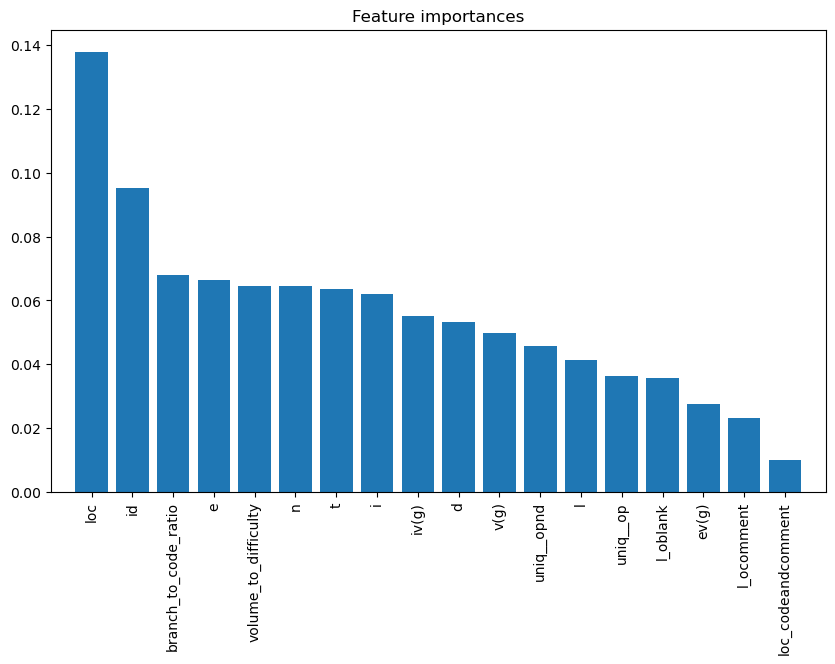

In [35]:
# Обучаем модель Random Forest
model_rf = RandomForestClassifier(random_state=1)
model_rf.fit(features_train, target_train)

# Получаем важность признаков
importances = model_rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Печатаем важность признаков
print("Feature ranking:")
for f in range(features_train.shape[1]):
    print(f"{f + 1}. {features_train.columns[indices[f]]} ({importances[indices[f]]})")

# Визуализируем важность признаков
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(features_train.shape[1]), importances[indices], align="center")
plt.xticks(range(features_train.shape[1]), features_train.columns[indices], rotation=90)
plt.xlim([-1, features_train.shape[1]])
plt.show()

In [36]:
# Формирование нового DataFrame с отобранными признаками
selected_features = ['loc', 'id', 'e', 't', 'n', 'volume_to_difficulty', 'i', 'branch_to_code_ratio']
df_selected = df[selected_features + ['defects']]

- данный метод не помог улучшить результат val_roc_auc: она остается в районе 0.78, далее его рассматривать не буду (проверенно)

In [37]:
# from imblearn.over_sampling import SMOTE
# from collections import Counter

# # Проверка начального распределения классов
# print("Original dataset shape:", Counter(target_train))

# # Применение SMOTE
# smote = SMOTE(random_state=1)
# X_resampled, y_resampled = smote.fit_resample(features_train, target_train)

# # Проверка нового распределения классов
# print("Resampled dataset shape:", Counter(y_resampled))

# # Стандартизация признаков
# scaler = StandardScaler()

# # Стандартизация обучающей выборки
# features_train_scaled = scaler.fit_transform(X_resampled)

# # Стандартизация тестовой выборки
# features_test_scaled = scaler.transform(features_test)  # Замените 'y_resampled' на 'features_test'

# # Теперь у вас будут стандартизированные признаки
# print("Преобразованные признаки обучающей выборки:")
# print(features_train_scaled[:5])  # показать первые 5 строк
# print("Преобразованные признаки тестовой выборки:")
# print(features_test_scaled[:5])    # показать первые 5 строк

- SMOTE помогает увеличить представление меньшинства путем создания новых синтетических образцов, что может уменьшить влияние дисбаланса классов. Однако для данной задачи данный метод регуляризации не помог улучшить результат для roc_auc. 

In [38]:
# Масштабирование данных
scaler = StandardScaler()
# Стандартизация обучающей выборки
features_train = scaler.fit_transform(features_train)
# Стандартизация тестовой выборки
features_test = scaler.transform(features_test)

print("Преобразованные признаки обучающей выборки:")
print(features_train[:2])  # показать первые 2 строки
print("Преобразованные признаки тестовой выборки:")
print(features_test[:2])    # показать первые 2 строки

Преобразованные признаки обучающей выборки:
[[ 0.61191559 -0.22924149  0.06447191  0.46278173  0.4511762  -0.05167313
  -0.5160055   0.22625587 -0.04988174 -0.07179414 -0.07624037 -0.29676586
   0.00275178 -0.19653932  0.92142087  0.13495929 -0.00451903  0.95538755]
 [ 1.21017308 -0.0256013  -0.44482223 -0.39715859 -0.27157931  0.20924189
  -0.81551004  1.16062094 -0.23242685 -0.0099845  -0.00863528  0.20562291
  -0.31012841  0.79480307  0.6200312  -0.1443816  -0.00451903 -1.12868903]]
Преобразованные признаки тестовой выборки:
[[ 4.65491788e-01  6.36129549e+00  1.46503079e+00  4.62781725e-01
   2.25806500e+00  6.16390239e+00 -9.15344882e-01  2.67834994e+00
   9.90819372e+00  2.63487614e+00  2.91232546e+00  5.39697354e+00
   1.23615191e+01 -1.96539321e-01  1.52420019e+00  8.51518594e+00
  -4.51902797e-03 -1.10951841e+00]
 [ 1.56338093e+00 -4.51394418e-01 -5.72145765e-01 -3.97158593e-01
  -4.52268195e-01 -3.82165486e-01 -1.16666111e-01 -2.59529735e-01
  -5.72248300e-01 -1.05829698e-01 -

In [39]:
# Обучение модели
def generate_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=features_train.shape[1]))  # Рекомендуется использовать input_shape
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[AUC(name='roc_auc')]
                  )
    
    return model

In [40]:
# Указываем классы как массив NumPy
classes = np.array([False, True])

# Вычисляем веса классов
class_weights = compute_class_weight('balanced', classes=classes, y=target_train)

# Преобразуем в словарь
class_weight_dict = {False: class_weights[0], True: class_weights[1]}
class_weight_dict

{False: 0.6465318699471084, True: 2.2061134897837515}

In [41]:
model = generate_model()

# Обучаем модель
history = model.fit(features_train, target_train,
                    validation_data=(features_test, target_test),
                    epochs=20,
                    batch_size=128,
                    class_weight=class_weight_dict)

# Вычисляем предсказания вероятностей на тестовых данных
test_pred_proba = model.predict(features_test)

# Вычисляем ROC AUC с помощью roc_auc_score из sklearn
roc_auc = roc_auc_score(target_test, test_pred_proba)

# Выводим результат
print(f'ROC AUC Score (sklearn): {roc_auc:.4f}')

Epoch 1/20


c:\Users\olyao\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


637/637 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5727 - roc_auc: 0.7709 - val_loss: 0.5647 - val_roc_auc: 0.7876
Epoch 2/20
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5597 - roc_auc: 0.7840 - val_loss: 0.5591 - val_roc_auc: 0.7909
Epoch 3/20
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5567 - roc_auc: 0.7885 - val_loss: 0.5355 - val_roc_auc: 0.7888
Epoch 4/20
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5495 - roc_auc: 0.7930 - val_loss: 0.5439 - val_roc_auc: 0.7917
Epoch 5/20
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5551 - roc_auc: 0.7902 - val_loss: 0.5401 - val_roc_auc: 0.7906
Epoch 6/20
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5518 - roc_auc: 0.7901 - val_loss: 0.5638 - val_roc_auc: 0.7907
Epoch 7/20
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5507 - roc_auc: 0.7912 - val_loss: 0.5617 - val_roc_auc: 0.7902
Epoch 8/20
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5511 - roc_auc: 0.7913 - val_loss: 0.5667 - val_roc_auc: 0.7897
Epo

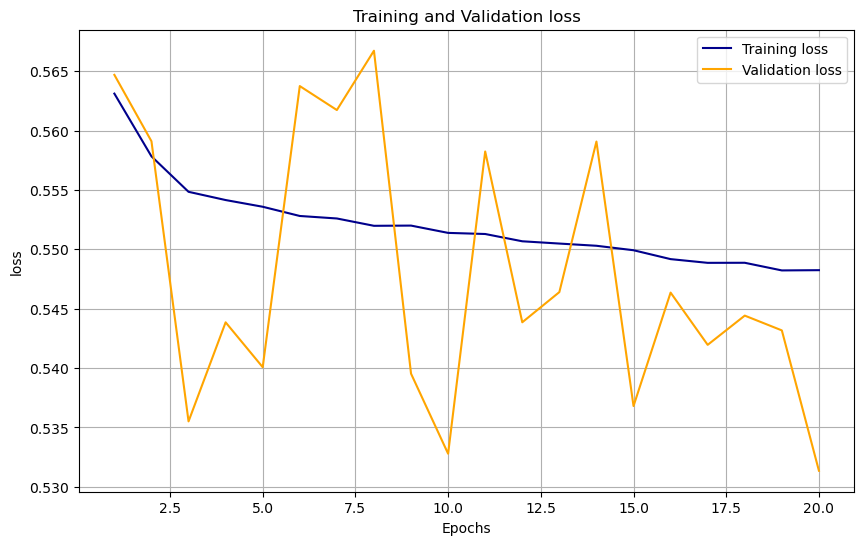

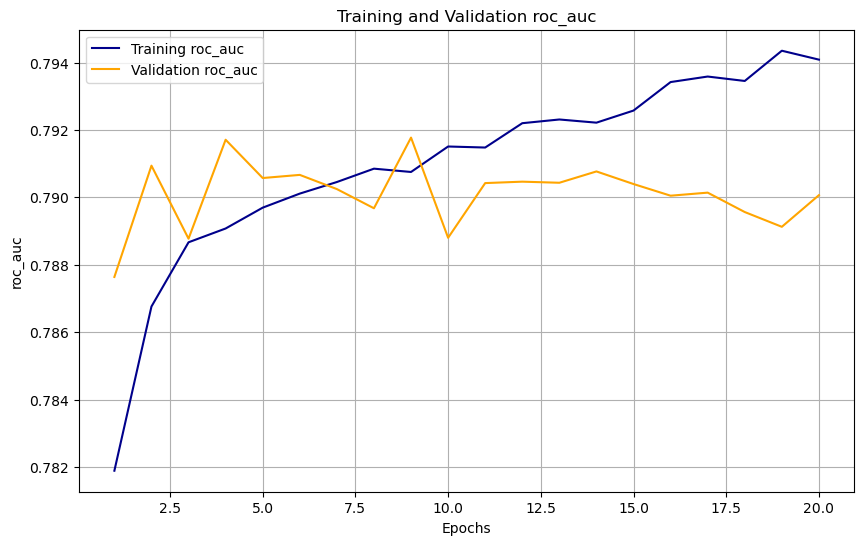

In [42]:
# Получение значений лосса и валидационного лосса из истории
def check_metrics(history, metric_name):

    # Получаем значения для заданной метрики
    train_metrics = history.history[metric_name]
    val_metrics = history.history[f'val_{metric_name}']

    # Построение графика
    epochs = range(1, len(train_metrics) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_metrics, label=f'Training {metric_name}', color='darkblue')
    plt.plot(epochs, val_metrics, label=f'Validation {metric_name}', color='orange')
    
    # Настройка графика
    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid()
    plt.show()

# Использование функции для построения графиков лосса и AUC
check_metrics(history, 'loss')
check_metrics(history, 'roc_auc')  # Для метрики AUC


7. _Собрав финальный датасет, который состоит из отфильтрованных (или добавленных) новых признаков, добавьте в вашу модель методы регуляризации — BatchNorm, Dropout, EarlyStopping, а также реализуйте автоматическое сохранение наилучших весов по метрике ROC_AUC на лучшей эпохе._

In [43]:
df_no_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101763 entries, 0 to 101762
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    101763 non-null  int64  
 1   loc                   101763 non-null  float64
 2   v(g)                  101763 non-null  float64
 3   ev(g)                 101763 non-null  float64
 4   iv(g)                 101763 non-null  float64
 5   n                     101763 non-null  float64
 6   l                     101763 non-null  float64
 7   d                     101763 non-null  float64
 8   i                     101763 non-null  float64
 9   e                     101763 non-null  float64
 10  t                     101763 non-null  float64
 11  l_ocomment            101763 non-null  int64  
 12  l_oblank              101763 non-null  int64  
 13  loc_codeandcomment    101763 non-null  int64  
 14  uniq__op              101763 non-null  float64
 15  

In [44]:
# Функция для генерации модели с добавлением Batch Normalization и Dropout
def generate_model():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_dim=features_train.shape[1]))
    model.add(BatchNormalization())  # Добавляем Batch Normalization
    model.add(Dropout(0.7))  # Добавляем Dropout с заданной вероятностью
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())  # Добавляем Batch Normalization
    model.add(Dropout(0.6))  # Добавляем Dropout
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[AUC(name='roc_auc')]  # Используется для контроля процесса обучения
                  )
    
    return model

# Создаем модель
model = generate_model()

# Определяем колбэки для обучения
early_stopping = EarlyStopping(monitor='val_roc_auc', patience=10, verbose=1, mode='max', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_roc_auc', save_best_only=True, mode='max', verbose=1)

# Обучаем модель с колбэками
history = model.fit(features_train, target_train,
                    validation_data=(features_test, target_test),
                    epochs=220,
                    batch_size=128,
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping, model_checkpoint])

# Вычисляем предсказания вероятностей на тестовых данных
test_pred_proba = model.predict(features_test)

# Вычисляем ROC AUC с помощью roc_auc_score из sklearn
roc_auc = roc_auc_score(target_test, test_pred_proba)

# Выводим результат
print(f'ROC AUC Score (sklearn): {roc_auc:.4f}')


Epoch 1/220


c:\Users\olyao\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


619/637 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7404 - roc_auc: 0.6887
Epoch 1: val_roc_auc improved from -inf to 0.78459, saving model to best_model.keras
637/637 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.7380 - roc_auc: 0.6897 - val_loss: 0.5489 - val_roc_auc: 0.7846
Epoch 2/220
629/637 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5822 - roc_auc: 0.7656
Epoch 2: val_roc_auc improved from 0.78459 to 0.78751, saving model to best_model.keras
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5822 - roc_auc: 0.7656 - val_loss: 0.5532 - val_roc_auc: 0.7875
Epoch 3/220
623/637 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5729 - roc_auc: 0.7709
Epoch 3: val_roc_auc improved from 0.78751 to 0.78875, saving model to best_model.keras
637/637 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5729 - roc_auc: 0.7710 - val_loss: 0.5566 - val_roc_auc: 0.7887
Epoch 4/220
628/637 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5693 - roc_auc: 0.7752
Epoch 4: val_roc_auc improved from 0.78875 to 0.78998, saving 

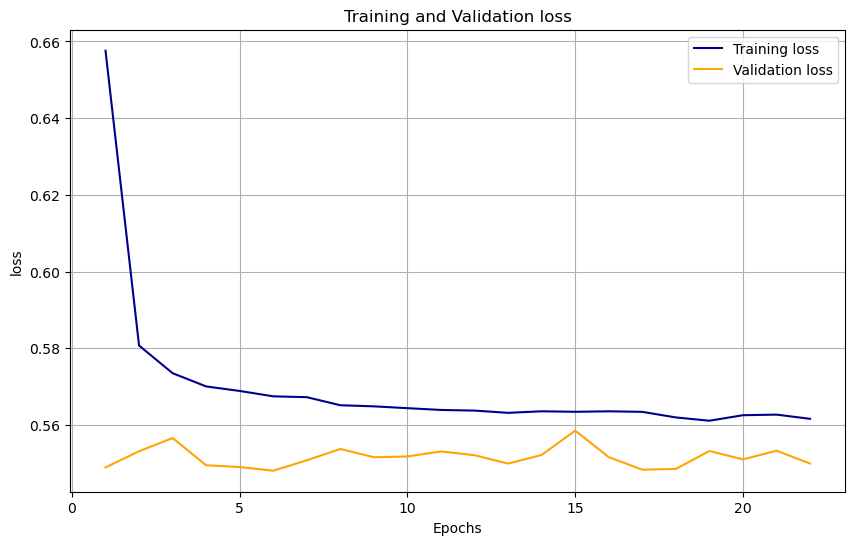

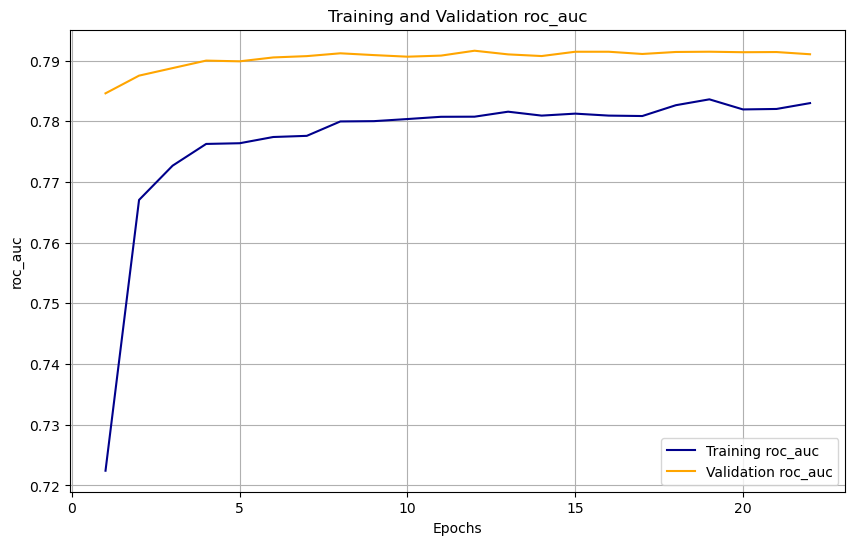

In [45]:
# Получение значений лосса и валидационного лосса из истории
def check_metrics(history, metric_name):

    # Получаем значения для заданной метрики
    train_metrics = history.history[metric_name]
    val_metrics = history.history[f'val_{metric_name}']

    # Построение графика
    epochs = range(1, len(train_metrics) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_metrics, label=f'Training {metric_name}', color='darkblue')
    plt.plot(epochs, val_metrics, label=f'Validation {metric_name}', color='orange')
    
    # Настройка графика
    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid()
    plt.show()

# Использование функции для построения графиков лосса и AUC
check_metrics(history, 'loss')
check_metrics(history, 'roc_auc')  # Для метрики AUC


8. _Напишите вывод по всему проекту, он должен содержать в себе:_

- Какие методы регуляризации улучшили качество, а какие плохо повлияли
- Какие признаки повлияли на качество обучения (в лучшую сторону)
- Наилучшую метрику ROC_AUC на валидации

### <span style="color: orange; font-weight: bold;">Вывод по проекту</span>

В ходе выполнения проекта по построению модели нейронной сети для решения задачи бинарной классификации были проведены обширные эксперименты, включающие выбор методов регуляризации и модификацию исходного набора данных. Далее представлены результаты и ключевые выводы из исследования.

#### 1. Методы регуляризации

В процессе обучения модели нейронной сети были рассмотрены следующие методы регуляризации:

- SMOTE (Synthetic Minority Over-sampling Technique): Этот метод предназначен для увеличения представления класса меньшинства за счет создания новых синтетических образцов. Тем не менее, в данном случае применение SMOTE не привело к улучшению метрики ROC AUC, и результат остался на уровне 0.7902. Возможно, увеличение объема выборки меньшинства не оказало достаточно сильного влияния на качество модели.

- Формирование нового DataFrame с отобранными признаками: Когда был создан DataFrame, содержащий только отборные признаки, не удалось улучшить результаты валидной метрики ROC AUC, которая осталась на уровне 0.78. Это указывает на то, что не все признаки в новом наборе данных оказывались информативными для поставленной задачи.

- Создание границ для выбросов: Применение данного метода, включая вычисление границ для верхних 5% значений, также оказало негативное влияние на результат. Это может свидетельствовать о том, что удаление выбросов затронуло важную информацию в данных.

- Вычисление границ для числовых признаков с использованием IQR (Interquartile Range): Этот метод также способствовал ухудшению качества модели, возможно из-за удаления полезных данными, которые могли бы улучшить предсказания.

- Задание порога для высоких корреляций: Установка порога в 0.9 для удаления коррелирующих признаков не дала значительных улучшений. Это может указывать на то, что высококоррелированные признаки содержали ценную информацию, и их исключение снизило качество модели.


#### 2. Влияние признаков на качество обучения

В ходе экспериментов с генерацией и удалением признаков были выявлены следующие основные наблюдения:

- Отрицательное влияние на качество обучения: Добавление новых признаков, основанных на EDA (Exploratory Data Analysis), не дало заметных улучшений в предсказательной способности модели. Линейно зависимые признаки или коррелирующие с другими признаками не добавили ценности. Удаление ненужных признаков (например, тех, которые имели низкое влияние на зависимую переменную или высокую корреляцию с другими признаками) также не смогло улучшить качество модели.

- Единственное положительное влияние: Изменение параметра test_size в функции train_test_split с 0.2 на 0.3 стало одним из немногих позитивных изменений. Это увеличение размера тестовой выборки способствовало более надежной оценке модели на валидационных данных, что несколько улучшило стабильность и надежность оценок метрики ROC AUC.

#### 3. Наилучшая метрика ROC AUC на валидации

- Без регуляризации: Первоначально, при обучении модели на исходной тренировочной выборке без каких-либо методов регуляризации, была достигнута ROC AUC Score (sklearn): 0.7951.

#### Заключение

В целом, проект продемонстрировал значимость тщательного выбора методов регуляризации и обработки данных для достижения лучших результатов в машинном обучении. Методы, как SMOTE и различные подходы к работе с выбросами и коррелирующими признаками, не привели к ожидаемым улучшениям качества модели. Полученные результаты подчеркивают необходимость глубокого анализа и тестирования различных подходов в процессе подготовки данных и построения моделей, что может стать основой для будущих исследований и улучшений.


PS создадим пайплайн и посмотрим score в df_selected:

In [46]:
# Предположим, ваша целевая переменная называется 'defects'
X = df_selected.drop('defects', axis=1)
y = df_selected['defects']

# 1. Разделение данных на обучающую и тестовую выборки
train_features, test_features, train_target, test_target = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Установим предобработку с помощью ColumnTransformer (пример)
numeric_features = train_features.select_dtypes(include=['int64', 'float64']).columns
categorical_features = train_features.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Стандартизация числовых признаков
        ('cat', OneHotEncoder(), categorical_features)  # Кодирование категориальных признаков
    ])

# 3. Создание полного пайплайна с SMOTE и классификаторами
pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  # SMOTE теперь корректно добавлен
    ('classify', LogisticRegression(class_weight='balanced', random_state=0))
])

# 4. Параметры для GridSearchCV
params = [
    {'classify': [LogisticRegression(class_weight='balanced', random_state=0)],
     'classify__C': [0.01, 0.1, 1, 10, 100]},
    {'classify': [DecisionTreeClassifier(class_weight='balanced', random_state=0)],
     'classify__max_depth': [2, 5, 10, 20]},
]

# 5. Поиск лучших гиперпараметров на тренировочных данных
grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, scoring='roc_auc')
grid_search.fit(X=train_features, y=train_target)

# 6. Получаем информацию о наилучшей модели
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# 7. Получаем предсказания меток классов и вероятностей на тестовых данных
test_pred_proba = best_model.predict_proba(test_features)[:, 1]
test_pred = best_model.predict(test_features)

# 8. Оценка качества модели на тестовой выборке
roc_auc = roc_auc_score(test_target, test_pred_proba)

# 9. Выводим отчет о качестве классификации для лучшей модели
print("Лучшие параметры модели:")
if isinstance(best_model.named_steps['classify'], LogisticRegression):
    model_name = "LogisticRegression"
    model_params = f"Регуляризационный параметр модели: C = {best_params['classify__C']}"
elif isinstance(best_model.named_steps['classify'], DecisionTreeClassifier):
    model_name = "DecisionTreeClassifier"
    model_params = f"max_depth = {best_params['classify__max_depth']}"

print(f"Используемая модель: {model_name}")
print(model_params)

# 10. Выводим отчет о качестве классификации
print("\nОтчет о качестве классификации:")
print(classification_report(test_target, test_pred))

# 11. Вычисляем и выводим метрику ROC-AUC
print(f"\nROC-AUC Score: {roc_auc:.2f}")

Лучшие параметры модели:
Используемая модель: LogisticRegression
Регуляризационный параметр модели: C = 0.01

Отчет о качестве классификации:
              precision    recall  f1-score   support

       False       0.88      0.83      0.86     15740
        True       0.52      0.61      0.56      4613

    accuracy                           0.78     20353
   macro avg       0.70      0.72      0.71     20353
weighted avg       0.80      0.78      0.79     20353


ROC-AUC Score: 0.78
